In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, neighbors
from sklearn.datasets import load_breast_cancer as load_bc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, \
                                    StratifiedKFold, train_test_split
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score, make_scorer
from sklearn.preprocessing import scale
from IPython.display import Image
from IPython.display import display
from IPython.core.display import HTML 

pd.options.display.max_columns = None
pd.options.display.max_rows = None

image_fna_process = "https://d4j2i6ubvolvu.cloudfront.net/sites/default/files/thumbnails/image/Diagram-of-fine-needle-aspiration-of-the-breast.png"
image_fna_computed = "https://www.researchgate.net/profile/Tsuyoshi_Kataoka/publication/51780466/figure/fig4/AS:196111148032003@1423767949986/Fine-needle-aspiration-cytology-demonstrated-sheet-clusters-of-atypical-epithelial-cells.png"

# Breast Cancer Detection with kNN and Parzen windows

### Alim Bukharaev, 776

In this homework assignment done as a part of Machine Learning classes at Moscow Institute of Physics and Technology I am trying to train k-Nearest-Neighbors and Parzen-window models to classify data entries describing characteristics of brest mass as either benign or malignant. It is common knowledge that in the modern-day world one out of eighnt women already has or will develop breast cancer at some point of her life. Thus, if machines could solve this essential problem faster and more accurately, not only would it improve overall life quality, but also save many lives around the globe.

As it's been aforementioned, in this particular notebook I am only using kNNs and fixed-radius algorithms, trying to hyper-tune them, having done some data-preproccesing before that. 

In [2]:
x = Image(url=image_fna_process) 
y = Image(url=image_fna_computed) 
display(x, y)

## 1. Let's have a look at the dataset

### 1.1 Analyzing samples 

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

This dataset is also available on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29



$\textbf{Ten real-valued features are computed for each cell nucleus:}$


$\textbf{a)}$ radius (mean of distances from center to points on the perimeter)

$\textbf{b)}$ texture (standard deviation of gray-scale values) 

$\textbf{c)}$ perimeter 

$\textbf{d)}$ area 

$\textbf{e)}$ smoothness (local variation in radius lengths) 

$\textbf{f)}$ compactness (perimeter^2 / area - 1.0) 

$\textbf{g)}$ concavity (severity of concave portions of the contour) 

$\textbf{h)}$ concave points (number of concave portions of the contour) 

$\textbf{i)}$ symmetry 

$\textbf{j)}$ fractal dimension ("coastline approximation" - 1)



The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All features are $\textit{real-valued}$ and are recoded with four significant digits.

$\textbf{Missing attribute values:}$ none
 
$\textbf{Class distribution:}$ 212 malignant (1), 357 benign (0)

### 1.2 Visual analysis 

 Let's see whether there are any strong correlations between the features

In [3]:
data = load_bc()
data_pandas = pd.DataFrame(data=data['data'], columns=data['feature_names'])
data['target'] = ~data['target'] + 2
data_pandas['class'] = data['target']
data_pandas.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,-0.012838


It comes as no surprise that features like '... radius' and '... perimeter', 'mean ...' and 'worst ...' are strongly correlated. It is also clear that the 'worst ...' features are more significant regarding the classification problem than the 'mean ...' ones. 

To prevent any multi-collinearity and make data more readable, let's only leave the 'worst ...' features

In [4]:
exceptions = {'worst radius', 'worst texture', 'worst compactness', 'worst concave points',
                'worst symmetry', 'worst fractal dimension', 'class'}

data_reduced = data_pandas.copy()

data_reduced = data_reduced.drop((set(data_pandas.columns) - exceptions), axis=1)

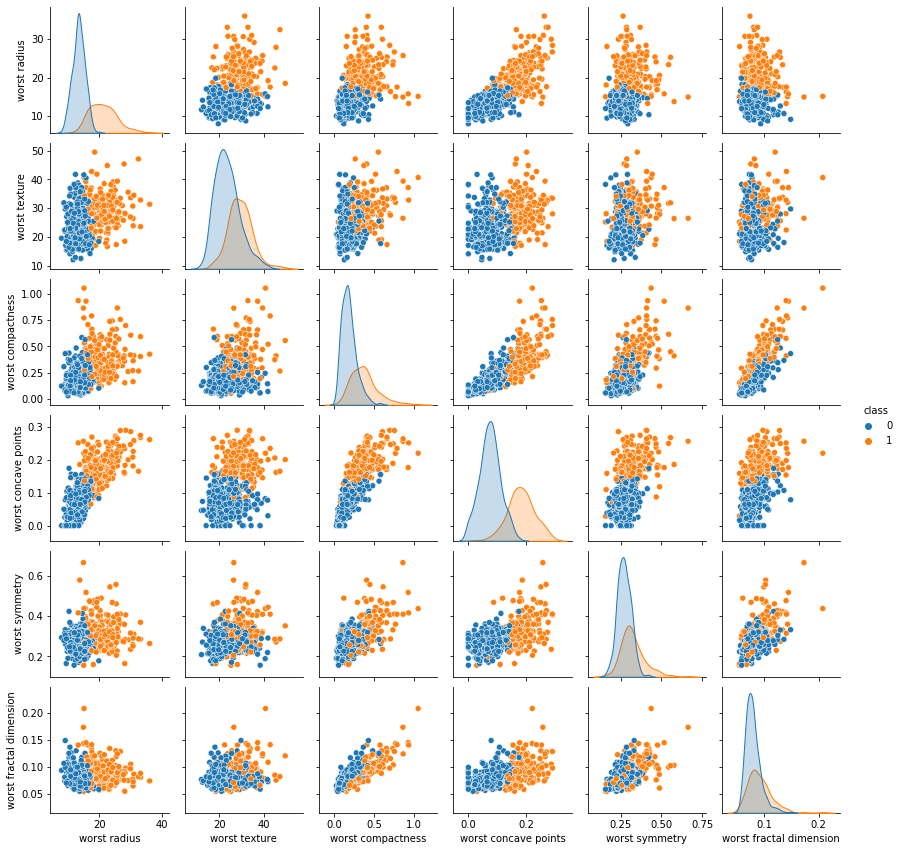

In [5]:
sns.pairplot(data_reduced, hue='class', height=2)
plt.show()

At the first glance, it seems neither of the pair-wise plots could be used to solve the classification problem. Let's see if machine learning can help us

## 2. Let's write a function that will help us use selected features! And let's normalize the data

In [6]:
def select_features(X, used_features, feature_names):
    """
    This function helps to use only the selected features while training and testing a model
    """
    d = {feature: j for feature, j in zip(feature_names, np.arange(len(feature_names)))}
        
    indices = []
    for feature in used_features:
        indices.append(d[feature])

    return X[..., np.array(indices)]


def unison_shuffled_copies(X, Y):
    """
    Let's shuffle the given data!
    """
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]


def grid_printer(grid, X, Y):
    """
    This function that prints grid search results
    """
    print('Best parameters are:', grid.best_params_)
    print('With best CV recall', round(grid.best_score_ * 100, 1), '%')
    scorers = [recall_score, precision_score, balanced_accuracy_score]
    prints = ['While recall on test is', 'Test precision is', 'Test balanced-accuracy is']
    for i in range(3):
        scorer = make_scorer(scorers[i])
        score = scorer(grid.best_estimator_, X, Y)
        print(prints[i], round(score * 100, 1), '%')

In [46]:
# normalizing data

X, Y = unison_shuffled_copies(np.copy(data['data']), np.copy(data['target']))

n_test = 100

X_train, Y_train = X[:-n_test], Y[:-n_test]
# m = X_train.mean(axis=0)
# s = X_train.std(axis=0)
# X_train = scale(X_train)

X_test, Y_test = X[-n_test:], Y[-n_test:]
# X_test, Y_test = (X[-n_test:] - m) / s, Y[-n_test:]

### KNN

In medical classification tasks, recall is generally prefered to all the other metrics. Indeed, it is much more important to detect all the ill patients than all the healthy ones. For this reason, the recall metric was used for refit.

To tune kNN, GridSearch iterated over k's from 1 to 100, tried default 'uniform' and 'distance' weights and also linearly decreasing weights from the seminar. The best of p's (p from Minkowski distance) was chosen from range 1-4

In [47]:
def func(distance):
    ret = np.ones_like(distance)
    k = ret.shape[1]
    for i in range(k):
        ret[:, i] *= (k-i)/k
    return ret

#### First, let's forget about scaling. For the sake of experiment

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
parameters = {'n_neighbors': np.arange(1, 100), 'weights': ['uniform', 'distance', func], 'p': np.arange(1, 5)}

clf = neighbors.KNeighborsClassifier()
grid_knn_all = GridSearchCV(estimator=clf, param_grid=parameters, scoring='recall', 
                    refit='recall', cv=skf.split(X_train, Y_train))

aux = grid_knn_all.fit(X_train, Y_train)
grid_printer(grid_knn_all, X_test, Y_test)

Best parameters are: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
With best CV recall 88.7 %
While recall on test is 94.3 %
Test precision is 97.1 %
Test balanced-accuracy is 96.4 %


#### Now using normalized data

In [50]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
parameters = {'clf__n_neighbors': np.arange(1, 100), 'clf__weights': ['uniform', 'distance', func], 'clf__p': np.arange(1, 5)}

clf = Pipeline([('S', StandardScaler()), ('clf', neighbors.KNeighborsClassifier())])
grid_knn_all = GridSearchCV(estimator=clf, param_grid=parameters, scoring='recall', 
                    refit='recall', cv=skf.split(X_train, Y_train))

aux = grid_knn_all.fit(X_train, Y_train)
grid_printer(grid_knn_all, X_test, Y_test)

Best parameters are: {'clf__n_neighbors': 1, 'clf__p': 1, 'clf__weights': 'uniform'}
With best CV recall 93.8 %
While recall on test is 100.0 %
Test precision is 89.7 %
Test balanced-accuracy is 96.9 %


###### We can see clearly that scaling really matters :\

#### Using only six out of thirty selected features

Now let's try using only the 6 features we selected in the begining and see whether it affects performance

In [51]:
used_features = ['worst radius', 'worst texture', 'worst compactness', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

X_train_ = select_features(X_train, used_features, data['feature_names'])
X_test_ = select_features(X_test, used_features, data['feature_names'])

grid_knn_selected = GridSearchCV(estimator=clf, param_grid=parameters, scoring='recall', 
                    refit='recall', cv=skf.split(X_train_, Y_train))
aux = grid_knn_selected.fit(X_train_, Y_train)
grid_printer(grid_knn_selected, X_test_, Y_test)

Best parameters are: {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}
With best CV recall 92.1 %
While recall on test is 94.3 %
Test precision is 91.7 %
Test balanced-accuracy is 94.8 %


We see that recall on test slightly dropped. Anyway, that is fine, regarding that we only used 6 features instead of 30.

### Parzen-windows

Now let's try a different approach. Let's focus our attention on kernels instead of the number of neighbors.

In [52]:
from functools import partial

def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

def K_linear(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - np.abs(ret)) * (np.abs(ret) <= 1)

def h_search(h):
    return partial(K, h=h)

def h_search_linear(h):
    return partial(K_linear, h=h)

#### We'll start with quadratic kernels

In [53]:
parameters = {'clf__weights': list(map(h_search, np.arange(0.4, 50, 0.2)))}

clf = Pipeline([('S', StandardScaler()), ('clf', neighbors.KNeighborsClassifier(n_neighbors=375))])
grid_pw_all = GridSearchCV(estimator=clf, param_grid=parameters, scoring='recall', 
                    refit='recall', cv=skf.split(X_train, Y_train))

aux = grid_pw_all.fit(X_train, Y_train)
grid_printer(grid_pw_all, X_test, Y_test)

Best parameters are: {'clf__weights': functools.partial(<function K at 0x7f80f821abf8>, h=4.600000000000001)}
With best CV recall 79.6 %
While recall on test is 77.1 %
Test precision is 100.0 %
Test balanced-accuracy is 88.6 %


#### Let's try using linear kernels

In [54]:
parameters = {'clf__weights': list(map(h_search_linear, np.arange(0.4, 50, 0.2)))}

clf = Pipeline([('S', StandardScaler()), ('clf', neighbors.KNeighborsClassifier(n_neighbors=375))])
grid_pw_all = GridSearchCV(estimator=clf, param_grid=parameters, scoring='recall', 
                    refit='recall', cv=skf.split(X_train, Y_train))

aux = grid_pw_all.fit(X_train, Y_train)
grid_printer(grid_pw_all, X_test, Y_test)

Best parameters are: {'clf__weights': functools.partial(<function K_linear at 0x7f80f306be18>, h=5.000000000000002)}
With best CV recall 80.8 %
While recall on test is 77.1 %
Test precision is 100.0 %
Test balanced-accuracy is 88.6 %


#### Using only six out of thirty selected features (linear)

In [55]:
grid_pw_selected = GridSearchCV(estimator=clf, param_grid=parameters, scoring='recall', 
                    refit='recall', cv=skf.split(X_train_, Y_train))
aux = grid_pw_selected.fit(X_train_, Y_train)
grid_printer(grid_pw_selected, X_test_, Y_test)

Best parameters are: {'clf__weights': functools.partial(<function K_linear at 0x7f80f306be18>, h=2.2000000000000006)}
With best CV recall 85.3 %
While recall on test is 85.7 %
Test precision is 90.9 %
Test balanced-accuracy is 90.5 %


A surprising increase in recall on test, but again, I believe it might have been both positive and negative, depending on your train/test split.

# Conclusion

It was quite surprising to me that it was possible to solve the problem with little to no loss in accuracy using just 1/5 of the features. But what struck me the most was that primitive kNN algorithm outran Parzen-window. I think that the main reason behind that was that data is never ditributed with equal density in the feature space and hence choosing the right kernel might be quite a painstaking process. So, sometimes, the simpler the model, the better :)

And scaling data really enhances the results!